In [ ]:
BASE_PATH = "/content/drive/MyDrive/Académico/UNIR/MUQC/99 - TFM/dev"

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import random
import time
import pandas as pd
# usaremos "from pennylane import numpy as np" tras la instalación de PennyLane para el uso de los métodos de diferenciación automática
#import numpy as np
import matplotlib.pyplot as plt

# Necesario en Pennylane para usar qml.qnn.KerasLayer sin problemas
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

#import tensorflow as tf
#tf.keras.backend.set_floatx("float64")

In [ ]:
#!pip install pennylane
!pip install scikit-learn==1.2.1
!pip install tensorflow==2.9.1
!pip install pennylane==0.26

In [ ]:
import tensorflow as tf
tf.keras.backend.set_floatx("float64")

In [ ]:
from pennylane import numpy as np

In [ ]:
N_QUBITS = 8

In [ ]:
RANDOM_SEED = 1234

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
PCA_COMPONENTS = 8

In [ ]:
df_tr_day_syn_resampled = pd.read_csv(BASE_PATH + "/dataset/tr_day_syn_small.csv")

In [ ]:
df_test_day_syn_resampled = pd.read_csv(BASE_PATH + "/dataset/test_day_syn_small.csv")

In [ ]:
x_tr = df_tr_day_syn_resampled.drop(columns = " Label").to_numpy()

In [ ]:
y_tr = df_tr_day_syn_resampled[" Label"].to_numpy()

In [ ]:
x_test = df_test_day_syn_resampled.drop(columns = " Label").to_numpy()

In [ ]:
y_test = df_test_day_syn_resampled[" Label"].to_numpy()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, train_size = 0.5, stratify = y_test)

In [ ]:
from sklearn.preprocessing import MaxAbsScaler

In [ ]:
scaler = MaxAbsScaler()
x_tr = scaler.fit_transform(x_tr)

x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

In [ ]:
x_test = np.clip(x_test, 0, 1)
x_val = np.clip(x_val, 0, 1)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components = PCA_COMPONENTS)

In [ ]:
start = time.time()

xs_tr = pca.fit_transform(x_tr)
xs_test = pca.transform(x_test)
xs_val = pca.transform(x_val)

end = time.time()
print(f"Elapsed time: {end - start} s")

Elapsed time: 0.020644664764404297 s


In [ ]:
import pennylane as qml

In [ ]:
dev = qml.device("lightning.qubit", wires = N_QUBITS)
# Averiguamos qué metodo de diferenciación se usará (al no especificarlo, será el "best")
qml.QNode.best_method_str(dev, "tensorflow")

'parameter-shift'

In [ ]:
# 1) Feature map: angle embedding
#qml.AngleEmbedding(data, wires = range(N_QUBITS))

# 2) Red neuronal: Two-Local
REPETITIONS = 1
def QNNTwoLocal(nqubits, theta, repetitions = 1):

  for r in range(repetitions):

    for i in range(nqubits):
      qml.RY(theta[r * nqubits + i], wires = i)
    for i in range(nqubits - 1):
      qml.CNOT(wires = [i, i + 1])

  for i in range(nqubits):
    qml.RY(theta[repetitions * nqubits + i], wires = i)

# 3) Método de medida: valor esperado de la matriz hermítica proyectora
# M = [1 0]
#     [0 0]
state_0 = [[1], [0]]
M = state_0 * np.conj(state_0).T

@qml.qnode(dev, interface = "tf")
def qnn_circ(inputs, theta):
  qml.AngleEmbedding(inputs, wires = range(N_QUBITS))
  QNNTwoLocal(nqubits = N_QUBITS, theta = theta, repetitions = REPETITIONS)
  return qml.expval(qml.Hermitian(M, wires = [0]))

qnn_parameters = (REPETITIONS + 1) * N_QUBITS

(<Figure size 1300x900 with 1 Axes>, <Axes: >)


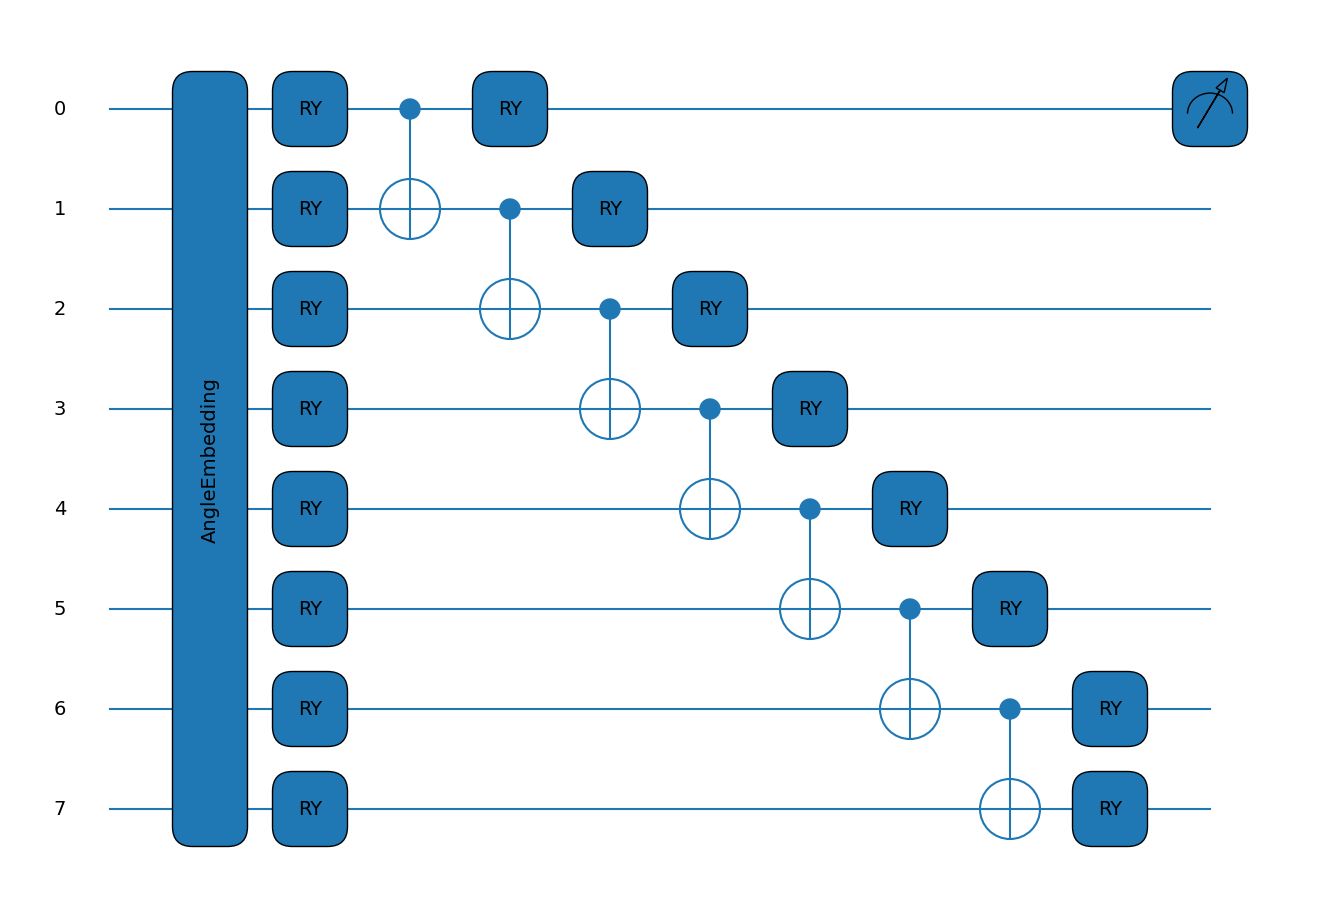

In [ ]:
print(qml.draw_mpl(qnn_circ)(xs_tr[0], np.random.random(qnn_parameters)))

In [ ]:
weights = {"theta": qnn_parameters}

qlayer = qml.qnn.KerasLayer(qnn_circ, weights, output_dim = 1)
model = tf.keras.models.Sequential([qlayer])

LEARNING_RATE = 0.005
opt = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)
model.compile(opt, loss = tf.keras.losses.BinaryCrossentropy())

PATIENCE = 2
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience = PATIENCE, verbose = 1,
    restore_best_weights = True)

In [ ]:
start = time.time()

In [ ]:
EPOCHS = 50
BATCH_SIZE = 20

history = model.fit(xs_tr, y_tr, epochs = EPOCHS, shuffle = True,
                    validation_data = (xs_val, y_val),
                    batch_size = BATCH_SIZE,
                    callbacks = [earlystop])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/pennylane/math/multi_dispatch.py:94: UserWarning: Contains tensors of types {'tensorflow', 'autograd'}; dispatch will prioritize TensorFlow and PyTorch over autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


40/40 [==============================] - 21s 513ms/step - loss: 2.1290 - val_loss: 1.9554
Epoch 2/50
40/40 [==============================] - 19s 487ms/step - loss: 1.5636 - val_loss: 1.3627
Epoch 3/50
40/40 [==============================] - 20s 491ms/step - loss: 1.1274 - val_loss: 0.9641
Epoch 4/50
40/40 [==============================] - 20s 491ms/step - loss: 0.8166 - val_loss: 0.6924
Epoch 5/50
40/40 [==============================] - 20s 490ms/step - loss: 0.5998 - val_loss: 0.5038
Epoch 6/50
40/40 [==============================] - 20s 491ms/step - loss: 0.4485 - val_loss: 0.3753
Epoch 7/50
40/40 [==============================] - 19s 477ms/step - loss: 0.3448 - val_loss: 0.2883
Epoch 8/50
40/40 [==============================] - 19s 478ms/step - loss: 0.2745 - val_loss: 0.2305
Epoch 9/50
40/40 [==============================] - 19s 481ms/step - loss: 0.2279 - val_loss: 0.1924
Epoch 10/50
40/40 [==============================] - 19s 478ms/step - loss: 0.1978 - val_loss: 0.1680


In [ ]:
end = time.time()
print(f"Elapsed time: {end - start} s")

Elapsed time: 978.9640765190125 s


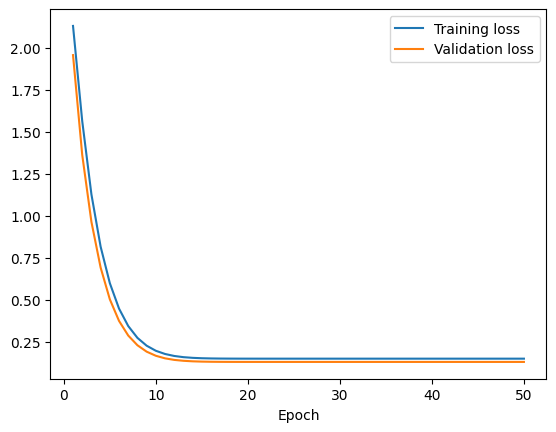

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(history):
  tr_loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  epochs = np.array(range(len(tr_loss))) + 1

  plt.plot(epochs, tr_loss, label = "Training loss")
  plt.plot(epochs, val_loss, label = "Validation loss")
  plt.xlabel("Epoch")
  plt.legend()
  plt.show()

plot_losses(history)

In [ ]:
from sklearn.metrics import accuracy_score

start = time.time()

tr_acc = accuracy_score(model.predict(xs_tr) >= 0.5, y_tr)
val_acc = accuracy_score(model.predict(xs_val) >= 0.5, y_val)
test_acc = accuracy_score(model.predict(xs_test) >= 0.5, y_test)

end = time.time()
print(f"Elapsed time: {end - start} s")

25/25 [==============================] - 5s 217ms/step


/usr/local/lib/python3.10/dist-packages/pennylane/math/multi_dispatch.py:94: UserWarning: Contains tensors of types {'tensorflow', 'autograd'}; dispatch will prioritize TensorFlow and PyTorch over autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


4/4 [==============================] - 1s 157ms/step


/usr/local/lib/python3.10/dist-packages/pennylane/math/multi_dispatch.py:94: UserWarning: Contains tensors of types {'tensorflow', 'autograd'}; dispatch will prioritize TensorFlow and PyTorch over autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


4/4 [==============================] - 1s 159ms/step
Elapsed time: 6.935023784637451 s


In [ ]:
print("Train accuracy:", tr_acc)
print("Validation accuracy:", val_acc)
print("Test accuracy:", test_acc)

Train accuracy: 0.9625
Validation accuracy: 0.95
Test accuracy: 0.97


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
output = model.predict(xs_test)
result = (output > 0.5).astype(float)

/usr/local/lib/python3.10/dist-packages/pennylane/math/multi_dispatch.py:94: UserWarning: Contains tensors of types {'tensorflow', 'autograd'}; dispatch will prioritize TensorFlow and PyTorch over autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


4/4 [==============================] - 1s 157ms/step


In [ ]:
confusion_matrix(y_true = y_test, y_pred = result)

array([[90,  0],
       [ 3,  7]])

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true = y_test, y_pred = result))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        90
           1       1.00      0.70      0.82        10

    accuracy                           0.97       100
   macro avg       0.98      0.85      0.90       100
weighted avg       0.97      0.97      0.97       100



In [ ]:
from sklearn.metrics import roc_curve

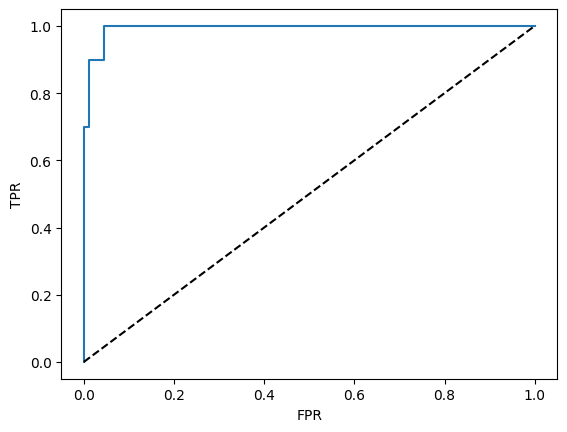

In [ ]:
fpr, tpr, _ = roc_curve(y_test, output)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle = "--", color = "black")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.show()

In [ ]:
from sklearn.metrics import auc

print(auc(fpr, tpr))

0.9933333333333334
